
## Overview

This script performs fine-tunes BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews. In addition to training a model, it preprocesses text into an appropriate format.


In [3]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

import os
 
os.chdir("/content/drive/MyDrive/Movie review project")

Mounted at /content/drive



## Installing and importing dependencies

First let us import all the modules and packages that will be required.


In [4]:
# A dependency of the preprocessing for BERT inputs
!pip data.shapeinstall -q tensorflow-text

ERROR: unknown command "data.shapeinstall"


In [5]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## BERT

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

Paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

## How to use BERT (Fine-tuning)

Using BERT for a specific task is relatively straightforward:

BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model:

 * Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.
 * In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.
 * In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.
 
 
Refs: https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

## Loading model from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

Here, we have used a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.


In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model. 

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [20]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on sample text and see the output:

In [21]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. 
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

In [22]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Defining model

We have created a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [23]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

For the fine-tuning I have used the`pooled_output` array which represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

In [24]:
classifier_model = build_classifier_model()

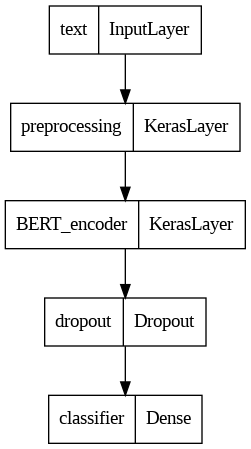

In [25]:
tf.keras.utils.plot_model(classifier_model)

## Model training

Next we train a model since we have the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), we'll use `losses.BinaryCrossentropy` loss function.

In [26]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

In [27]:
epochs = 5
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Next we compile the model with the loss, metric and optimizer.

In [28]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Now, we define the test and validation variables to input in the model for evaluation and prediction.

In [29]:
train_data = pd.read_csv('/content/drive/MyDrive/Movie review project/train_data.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/Movie review project/valid_data.csv')
X_train = train_data['text']
y_train = train_data['label']
X_valid = valid_data['text']
y_valid = valid_data['label']

In [30]:
X = data['review']
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(data.review,data.sentiment,random_state = 0 , stratify = data.sentiment)

#valid_size=5000
#X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
#X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]
X_train, X_test, y_train, y_test = train_test_split(data.review,data.sentiment, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.16, random_state=1) # 0.25 x 0.8 = 0.2
#print('Train Set ->', X_train.shape, y_train.shape)
#print('Validation Set ->', X_valid.shape, y_valid.shape)
#print('Test Set ->', X_test.shape, y_test.shape)

print('Number of reviews in the total set : {}'.format(len(X)))
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_valid)))
print('Number of reviews in the testing set : {}'.format(len(X_test)))

Number of reviews in the total set : 50000
Number of reviews in the training set : 33600
Number of reviews in the validation set : 49443
Number of reviews in the testing set : 10000


In [31]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_valid, y_valid),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1050/1050 [==============================] - 469s 438ms/step - loss: 0.4374 - binary_accuracy: 0.7794 - val_loss: 0.3668 - val_binary_accuracy: 0.8309
Epoch 2/5
1050/1050 [==============================] - 457s 435ms/step - loss: 0.3006 - binary_accuracy: 0.8675 - val_loss: 0.3991 - val_binary_accuracy: 0.8265
Epoch 3/5
1050/1050 [==============================] - 455s 434ms/step - loss: 0.2358 - binary_accuracy: 0.8998 - val_loss: 0.3889 - val_binary_accuracy: 0.8381
Epoch 4/5
1050/1050 [==============================] - 455s 434ms/step - loss: 0.2110 - binary_accuracy: 0.9161 - val_loss: 0.3889 - val_binary_accuracy: 0.8381
Epoch 5/5
1050/1050 [==============================] - 455s 434ms/step - loss: 0.2111 - binary_accuracy: 0.9176 - val_loss: 0.3889 - val_binary_accuracy: 0.8381


## Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [32]:
#X_test = test_data['text']
#y_test = test_data['label']
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 39s 125ms/step - loss: 0.3307 - binary_accuracy: 0.8698
Loss: 0.33073264360427856
Accuracy: 0.8697999715805054


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


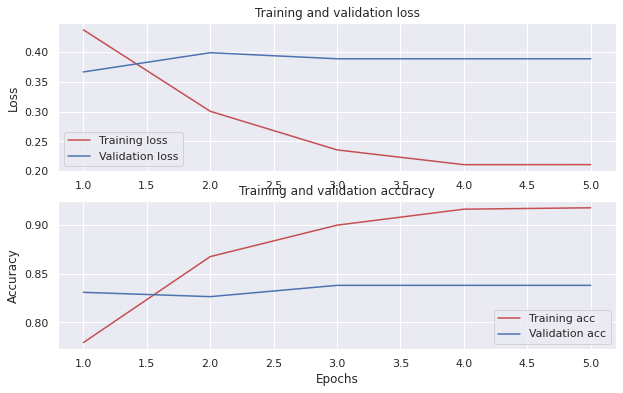

In [33]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Saving Model

Saving our fine-tuned model for later use.

In [34]:
dataset_name = 'imdb_2'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Reloading saved model

In [35]:
reloaded_model = tf.saved_model.load(saved_model_path)

 Testing our model on any sentence we want, by adding to the `examples` variable below.

In [36]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was idiotic.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997030
input: The movie was great!           : score: 0.988759
input: The movie was meh.             : score: 0.630100
input: The movie was idiotic.         : score: 0.006617
input: The movie was terrible...      : score: 0.001588

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997030
input: The movie was great!           : score: 0.988759
input: The movie was meh.             : score: 0.630100
input: The movie was idiotic.         : score: 0.006617
input: The movie was terrible...      : score: 0.001588

